# **Importing Libraries**

In [2]:
import os
import numpy as np
import librosa
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense
from tensorflow.keras.layers import  Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from pydub import AudioSegment
from pydub.playback import play


c:\Users\Wellc\anaconda3\envs\myevn\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# **ฟังก์ชันต่างๆ**

c:\Users\Wellc\anaconda3\envs\myevn\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 52s 668ms/step - accuracy: 0.1972 - loss: 4.4842 - val_accuracy: 0.2143 - val_loss: 11.1042
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 42s 600ms/step - accuracy: 0.3067 - loss: 1.6039 - val_accuracy: 0.1482 - val_loss: 12.9610
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.3082 - loss: 1.5909 - val_accuracy: 0.1482 - val_loss: 13.8951
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.3955 - loss: 1.4247 - val_accuracy: 0.1482 - val_loss: 52.7375


✅ CNN Model Training Complete & Saved


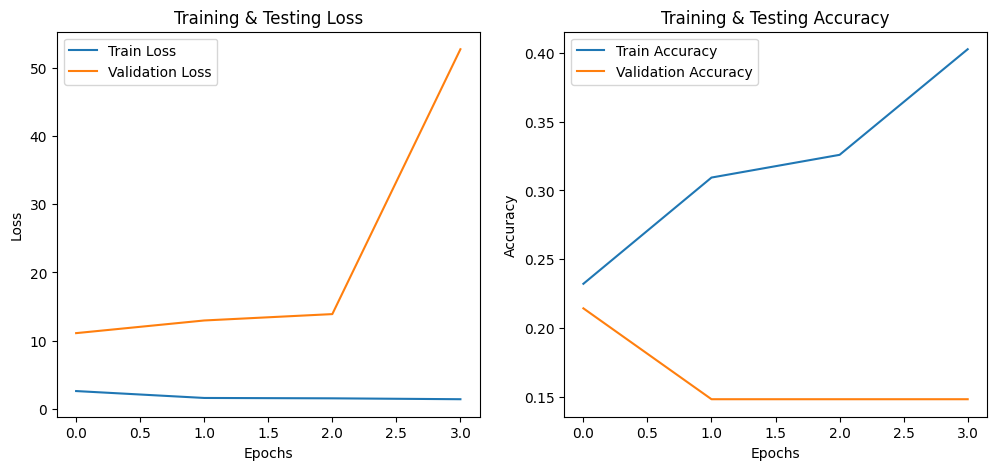

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


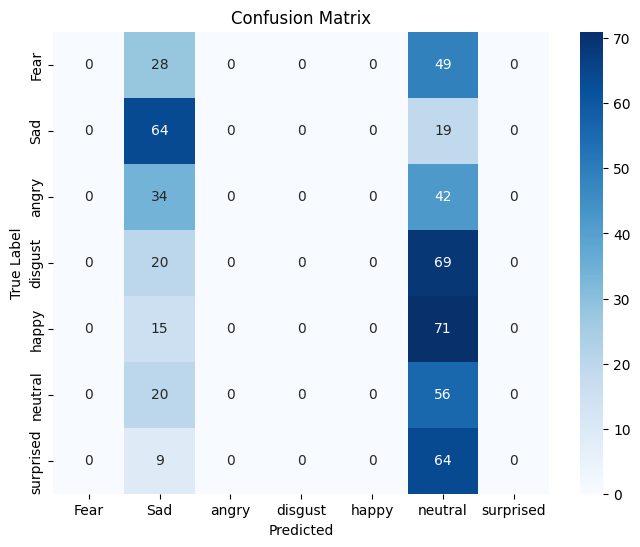

In [3]:
# ฟังก์ชันดึงฟีเจอร์จากไฟล์เสียง
def extract_features(file_path, max_pad_len=100):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Normalize MelSpectrogram
        mel_spec_db = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
        
        pad_width = max_pad_len - mel_spec_db.shape[1]
        if pad_width > 0:
            mel_spec_db = np.pad(mel_spec_db, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mel_spec_db = mel_spec_db[:, :max_pad_len]
        
        return mel_spec_db
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros((128, max_pad_len))

# โหลดข้อมูลจากโฟลเดอร์
def load_data_from_folder(audio_folder):
    filenames, labels = [], []
    for emotion in os.listdir(audio_folder):
        emotion_folder = os.path.join(audio_folder, emotion)
        if os.path.isdir(emotion_folder):
            for filename in os.listdir(emotion_folder):
                if filename.endswith(".wav"):
                    filenames.append(os.path.join(emotion_folder, filename))
                    labels.append(emotion)
    return filenames, labels

# ดึงฟีเจอร์จากทุกไฟล์
def extract_features_from_all(filenames, max_pad_len=100):
    return np.array([extract_features(file, max_pad_len) for file in filenames])

# โหลดข้อมูล
audio_folder = 'DATASET/TESS Toronto emotional speech set data'
filenames, labels = load_data_from_folder(audio_folder)

# แปลง labels เป็น One-hot
label_encoder = LabelEncoder()
y_encoded = to_categorical(label_encoder.fit_transform(labels))

# แปลงเสียงเป็น MelSpectrogram
X_features = extract_features_from_all(filenames)
X = X_features.reshape(X_features.shape[0], 100, 128, 1)  # (samples, timesteps, features, channels)

# แบ่ง train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# ฟังก์ชันสร้าง CNN Model
def create_cnn_model(input_shape, n_classes):
    model = Sequential()
    
    # CNN Layers
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))

    # Compile
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# สร้างโมเดล CNN
n_classes = len(label_encoder.classes_)
model = create_cnn_model((100, 128, 1), n_classes)

# ใช้ Early Stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train Model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, callbacks=[early_stop])

# บันทึกโมเดลและ Label Encoder
model.save('emotion_cnn_model.h5')
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print("✅ CNN Model Training Complete & Saved")


# กราฟ Loss และ Accuracy
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Loss Graph
    ax[0].plot(history.history['loss'], label='Train Loss')
    ax[0].plot(history.history['val_loss'], label='Validation Loss')
    ax[0].set_title('Training & Testing Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # Accuracy Graph
    ax[1].plot(history.history['accuracy'], label='Train Accuracy')
    ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[1].set_title('Training & Testing Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.show()

# เรียกใช้ฟังก์ชัน plot
plot_training_history(history)

# Confusion Matrix Heatmap
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# คำนวณ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# วาด Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



In [4]:
# แสดง Train และ Test Accuracy เป็นเปอร์เซนต์
train_accuracy = history.history['accuracy'][-1] * 100
test_accuracy = history.history['val_accuracy'][-1] * 100

print(f"Train Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")

Train Accuracy: 40.27%
Test Accuracy: 14.82%


# **การนำโมเดลไปทดสอบใช้งาน**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


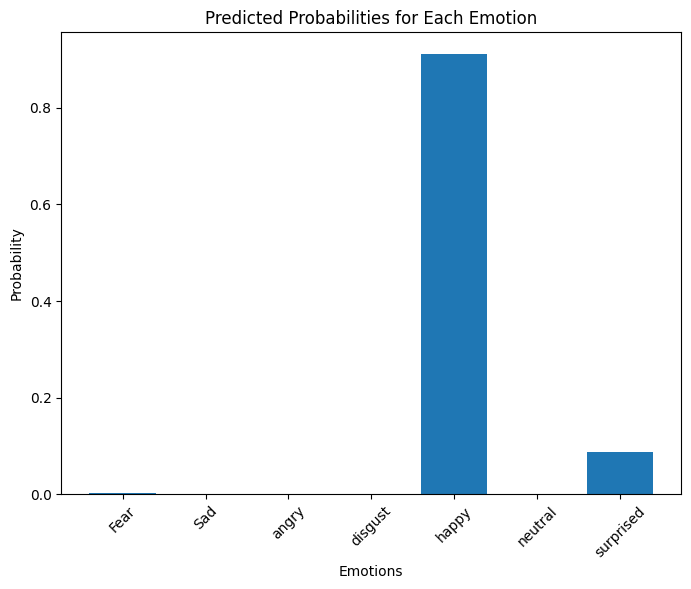

Predicted Emotion: happy


In [5]:
# กำหนด LabelEncoder จากไฟล์ที่บันทึกไว้
with open("label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

# โหลดโมเดล
model = load_model('emotion_crnn_model.h5')

def extract_features(audio_file_path, max_pad_len=100):
    # โหลดไฟล์เสียง
    y, sr = librosa.load(audio_file_path, sr=16000)

    # แปลงเสียงเป็น Mel Spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Normalize ข้อมูลให้อยู่ในช่วง 0-1 เหมือนตอน Train
    mel_spectrogram_db = (mel_spectrogram_db - np.min(mel_spectrogram_db)) / (np.max(mel_spectrogram_db) - np.min(mel_spectrogram_db))

    # บังคับให้มีขนาด max_pad_len (100) เหมือนตอน Train
    pad_width = max_pad_len - mel_spectrogram_db.shape[1]
    if pad_width > 0:
        mel_spectrogram_db = np.pad(mel_spectrogram_db, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_spectrogram_db = mel_spectrogram_db[:, :max_pad_len]

    return mel_spectrogram_db.T  # ทำ Transpose ให้ได้ (100, 128)



# ฟังก์ชันทำนายอารมณ์จากไฟล์เสียงและแสดงกราฟ
def predict_emotion_and_plot(audio_file_path):
    # ดึงฟีเจอร์จากไฟล์เสียงใหม่
    feature = extract_features(audio_file_path)
    feature = feature.reshape(1, feature.shape[0], feature.shape[1], 1)  # แปลงให้เป็น (batch_size, timesteps, features, channels)

    # ทำนายด้วยโมเดล
    prediction = model.predict(feature)
    
    # แปลงผลลัพธ์จากค่าที่ทำนายเป็น label (อารมณ์)
    predicted_index = np.argmax(prediction, axis=1)
    predicted_class = label_encoder.inverse_transform(predicted_index)[0]  # แปลงค่าที่ทำนายเป็น label
    
    # แสดงกราฟค่าความน่าจะเป็นของแต่ละอารมณ์
    plt.figure(figsize=(8, 6))
    plt.bar(label_encoder.classes_, prediction[0])
    plt.xlabel('Emotions')
    plt.ylabel('Probability')
    plt.title('Predicted Probabilities for Each Emotion')
    plt.xticks(rotation=45)
    plt.show()
    
    return predicted_class, prediction[0]

# เล่นไฟล์เสียง
def play_audio(test_file):
    sound = AudioSegment.from_file(test_file)
    play(sound)

# ทำนายเสียงและเล่นเสียง
test_file = 'DATASET/TESS Toronto emotional speech set data/happy/OAF_bar_happy.wav'

predicted_emotion, probabilities = predict_emotion_and_plot(test_file)
print(f"Predicted Emotion: {predicted_emotion}")
play_audio(test_file)


# **เปรียบเทียบความแตกต่างโดยใช้ Mel Spectrogram** 

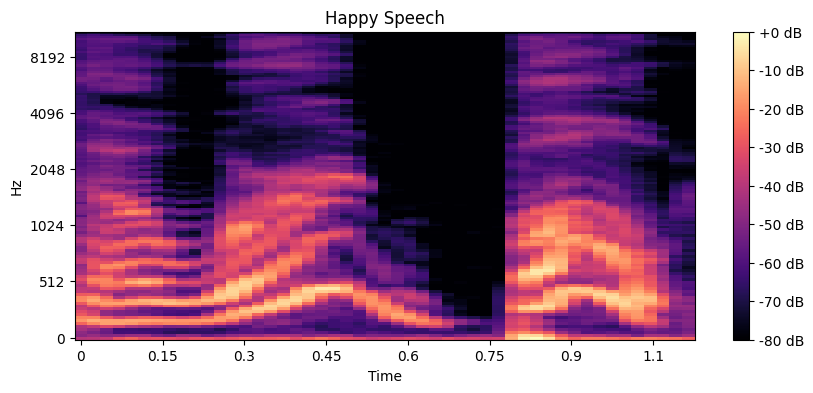

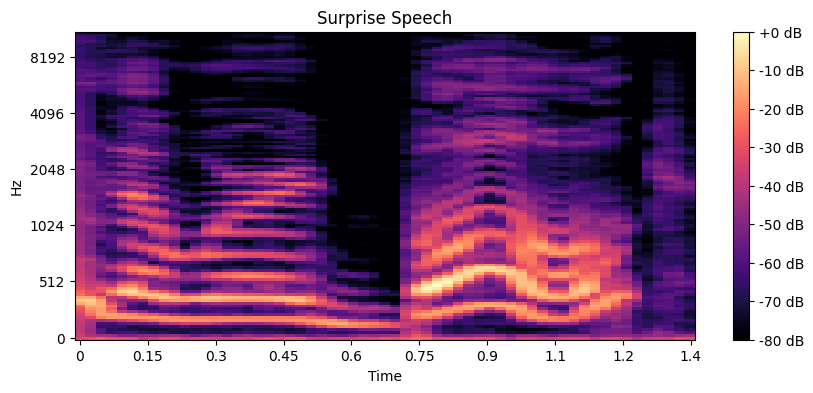

In [6]:
def plot_mel_spectrogram(audio_path, title):
    y, sr = librosa.load(audio_path, duration=3, offset=0.5)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram_db, x_axis="time", y_axis="mel", sr=sr)
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.show()
plot_mel_spectrogram("DATASET/TESS Toronto emotional speech set data/happy/OAF_boat_happy.wav", "Happy Speech")
plot_mel_spectrogram("DATASET/TESS Toronto emotional speech set data/surprised/OAF_boat_ps.wav", "Surprise Speech")
